In [10]:
# импорт прописанных классов
from preprocess import SurfaceDataLoader, DataCleaner
from correlation import CorrelationAnalyzer
from pipelines import Boosters, DTree, RandomForest, LogisticBinary, NeuralNet, KMeansClustering
from evaluation import ModelEvaluator

In [11]:
# создаём объект загрузчика данных
loader = SurfaceDataLoader(base_path="../datasets") # в __init__ изначально прописан такой путь, так что можно создавать объект и без аргументов

# загружаем один общий датафрейм со всеми поверхностями и столбцом label
full_data = loader.load_full_dataset()

In [12]:
# создаём объект для очистки данных со стратегией "drop"
# эта стратегия полностью удаляет строки, где есть хотя бы один пропуск (NaN), поэтому она удалит абсолютно все строки, это надо объяснить преподу
cleaner_drop = DataCleaner(missing_strategy="drop")

# применяем очистку - получаем новый датафрейм без строк с пропусками
full_data_drop = cleaner_drop.clean(full_data)

print("размер датасета до очистки (drop):", full_data.shape)
print("размер датасета после очистки (drop):", full_data_drop.shape)

размер датасета до очистки (drop): (54597, 45)
размер датасета после очистки (drop): (0, 45)


In [13]:
# создаём объект для очистки данных со стратегией "fill"
# nan значения заполняются в данном случае нулями, это регуляируется аргументом fill_value
cleaner_fill = DataCleaner(missing_strategy="fill", fill_value=0.0)

# применяем заполнение пропусков
full_data_fill = cleaner_fill.clean(full_data)

print("размер датасета после очистки (fill):", full_data_fill.shape)

print("есть ли пропуски после fill:", cleaner_fill.has_missing(full_data_fill))

размер датасета после очистки (fill): (54597, 45)
есть ли пропуски после fill: False


первые строки матрицы корреляции:


,0,1,2,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
0,1.000000,0.022536,-0.762211,-0.386863,0.762211,-0.368929,-0.333338,0.617619,-0.323089,-0.399201,...,0.738278,0.702440,0.068947,0.743921,0.692029,-0.384732,-0.394258,-0.094968,-0.324785,-0.191724
1,0.022536,1.000000,-0.065145,-0.876421,0.065146,0.860549,-0.728725,0.038032,0.721741,-0.860882,...,0.066390,0.039581,0.007829,0.047105,0.026798,0.845301,0.739630,0.013974,0.852131,0.786076
2,-0.762211,-0.065145,1.000000,0.537618,-1.000000,0.452225,0.469692,-0.825777,0.374533,0.548924,...,-0.991327,-0.923893,-0.016500,-0.966580,-0.829457,0.462866,0.486164,0.007527,0.408054,0.268368
4,-0.386863,-0.876421,0.537618,1.000000,-0.537618,-0.508919,0.842420,-0.430632,-0.429120,0.992326,...,-0.534484,-0.479290,-0.014578,-0.506247,-0.422916,-0.490900,-0.390366,-0.008176,-0.523122,-0.534715
5,0.762211,0.065146,-1.000000,-0.537618,1.000000,-0.452225,-0.469692,0.825777,-0.374533,-0.548924,...,0.991327,0.923893,0.016500,0.966581,0.829457,-0.462866,-0.486164,-0.007527,-0.408054,-0.268368



пары признаков с сильной корреляцией (|corr| >= 0.6):


,feature_1,feature_2,correlation
160,26,34,-1.000000
95,10,28,1.000000
110,12,38,1.000000
103,11,33,1.000000
29,2,5,-1.000000
...,...,...,...
86,9,22,0.637501
87,9,25,0.636986
2,0,8,0.617619
70,7,22,-0.612320


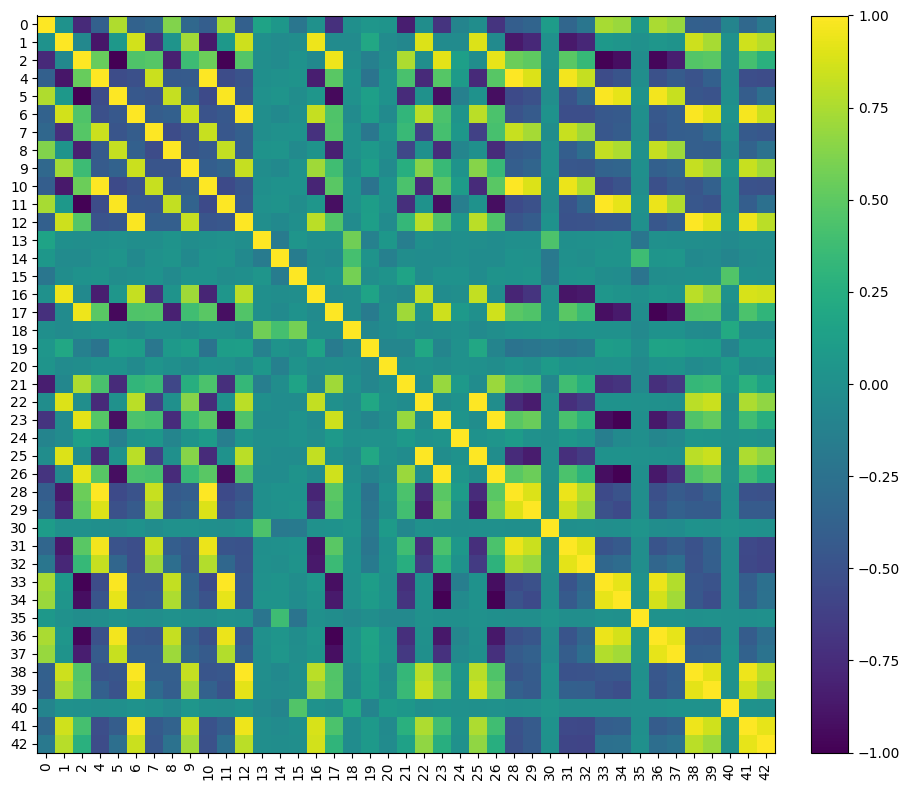

In [14]:
corr_analyzer = CorrelationAnalyzer(df=full_data_fill, label_column="label")

corr_matrix = corr_analyzer.compute_correlation_matrix()

print("первые строки матрицы корреляции:")
display(corr_matrix.head())

strong_pairs = corr_analyzer.find_strong_pairs(
    corr_matrix=corr_matrix,
    threshold=0.6  # порог можно поменять
)

print("\nпары признаков с сильной корреляцией (|corr| >= 0.6):")
display(strong_pairs)

corr_analyzer.plot_correlation_heatmap(
    corr_matrix=corr_matrix,
    figsize=(10, 8) # размер картинки можно поменять
)

In [15]:
X = cleaner_fill.select_training_columns(full_data_fill)
y = full_data_fill["label"]

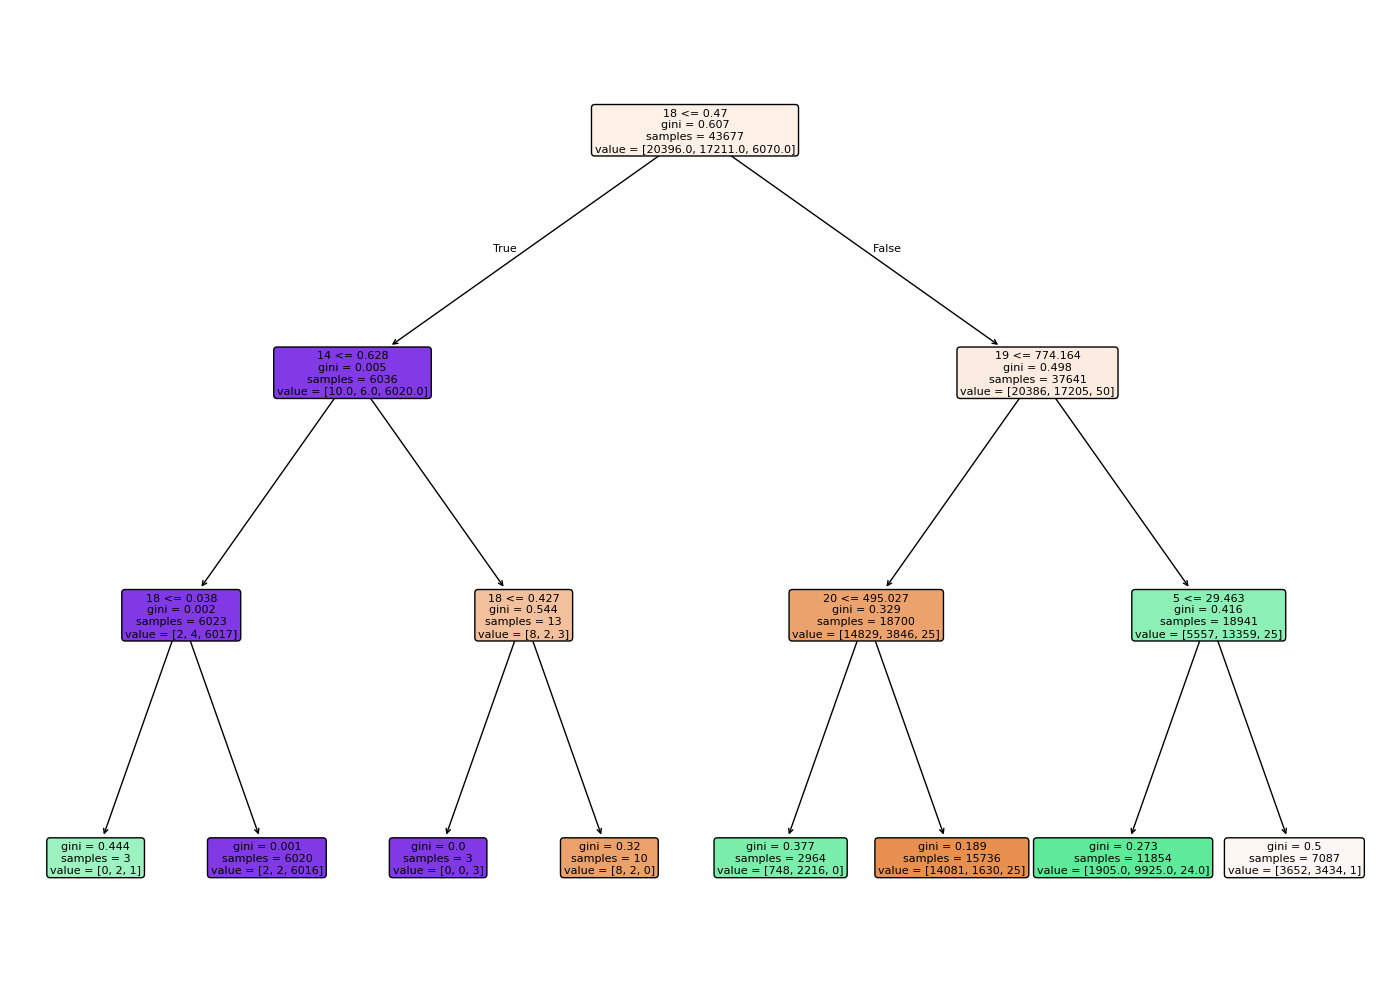

In [16]:
# создание объекта класса Dtree для визуализации его работы
trees_trainer = DTree(X, y, test_ratio=0.2, random_state=42)

# обучение дерева
tree_model = trees_trainer.train_tree(max_depth=3)

# визуализирует обученное дерево
trees_trainer.plot_tree(figsize=(14, 10))

In [17]:
# преобразование df для работы логистической регрессии
# модель в итоге будет предиктить label == table или green/gray surface
def to_binary(df):
      binary_df = df.copy()
      binary_df['is_table'] = (binary_df['label'] == 3).astype(int)
      binary_df.drop(columns=['label'], inplace=True)

      return binary_df

binary_df = to_binary(full_data_fill)
X_bin = cleaner_fill.select_training_columns(binary_df, target_column="is_table")
y_bin = binary_df["is_table"]

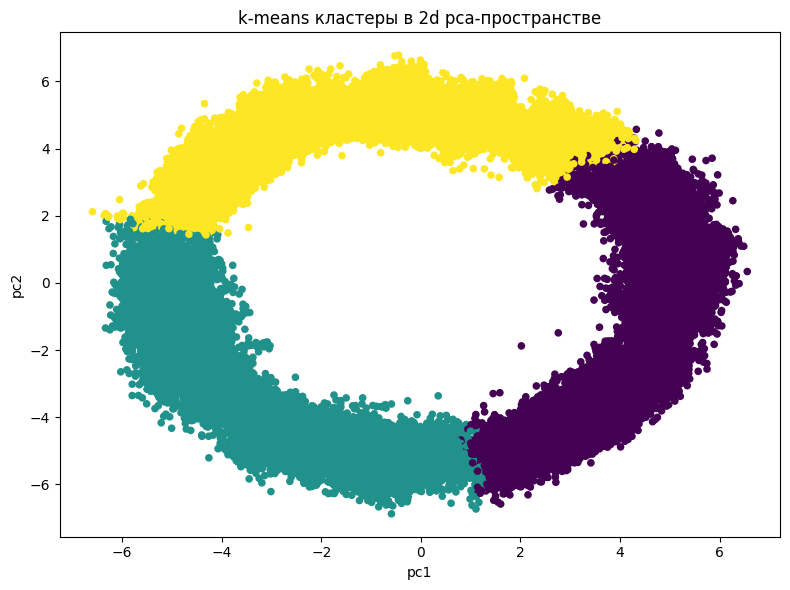

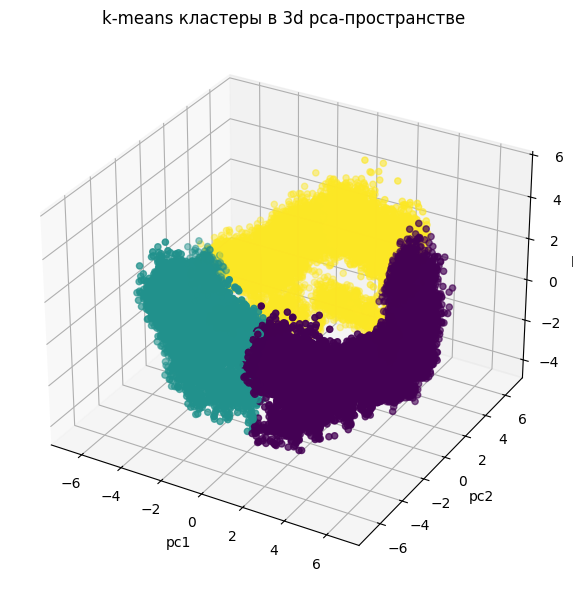

In [18]:
# создание объекта для визуализации kmeans
kmeans_clust = KMeansClustering(
    X,
    n_clusters=3,        # число кластеров
    random_state=42,     # для воспроизводимости
)

# обучает k-means и строит pca-проекции (2d и 3d)
kmeans_model = kmeans_clust.fit()

# визуализация в 2d
kmeans_clust.plot_2d(figsize=(8, 6))

# визуализация в 3d
kmeans_clust.plot_3d(figsize=(8, 6))

In [19]:
# обучение моделей с гиперпараметрами
random_state = 42
test_ratio = 0.2
boosters = Boosters(X, y, test_ratio=test_ratio)
tree_trainer = DTree(X, y, test_ratio=test_ratio, random_state=random_state)
rf_trainer = RandomForest(X, y, test_ratio=test_ratio, random_state=random_state)
logreg_trainer = LogisticBinary(X_bin, y_bin, test_ratio=test_ratio, random_state=random_state)
nn_trainer = NeuralNet(X_bin, y_bin, test_ratio=test_ratio, random_state=random_state)

# сетки при желании можно увеличить, но нужно будет дольше ждать пока обучатся модели
catboost_param_grid = {
    "depth": [4, 6],
    "learning_rate": [0.03, 0.1],
    "iterations": [200, 500],
}

lightgbm_param_grid = {
    "num_leaves": [31, 63],
    "max_depth": [-1, 7],
    "learning_rate": [0.03, 0.1],
}

xgboost_param_grid = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [200, 400],
}

tree_param_grid = {
    "max_depth": [3, 5, None],
    "min_samples_split": [2, 5],
}

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 7],
}

logreg_param_grid = {
    "C": [0.1, 1.0, 10.0],
    "penalty": ["l2"],
    "solver": ["lbfgs"],
}

nn_param_grid = {
    "hidden_layer_sizes": [(64,), (64, 32)],
    "learning_rate_init": [0.001, 0.01],
}


# бустинги
catboost_model_gs = boosters.train_catboost(param_grid=catboost_param_grid)
lightgbm_model_gs = boosters.train_lightgbm(param_grid=lightgbm_param_grid)
xgboost_model_gs = boosters.train_xgboost(param_grid=xgboost_param_grid)

# дерево и лес
tree_model_gs = tree_trainer.train_tree(param_grid=tree_param_grid)
rf_model_gs = rf_trainer.train_random_forest(param_grid=rf_param_grid)

# логистическая регрессия
logreg_model_gs = logreg_trainer.fit(param_grid=logreg_param_grid)

# полносвязная нейронная сеть
nn_model_gs = nn_trainer.fit(param_grid=nn_param_grid)

 многоклассовые модели с подбором гиперпараметров 

CatBoostClassifier:
  accuracy : 0.9988
  precision: 0.9985
  f1       : 0.9984

LGBMClassifier:
  accuracy : 0.9991
  precision: 0.9985
  f1       : 0.9986

XGBClassifier:
  accuracy : 0.9993
  precision: 0.9990
  f1       : 0.9989

DecisionTreeClassifier:
  accuracy : 0.9973
  precision: 0.9976
  f1       : 0.9977

RandomForestClassifier:
  accuracy : 0.9995
  precision: 0.9996
  f1       : 0.9996


 бинарные модели (is_table) с подбором гиперпараметров 

LogisticRegression:
  accuracy : 0.9981
  precision: 0.9961
  f1       : 0.9931
  auc      : 0.9979

MLPClassifier:
  accuracy : 0.9993
  precision: 0.9987
  f1       : 0.9974
  auc      : 1.0000


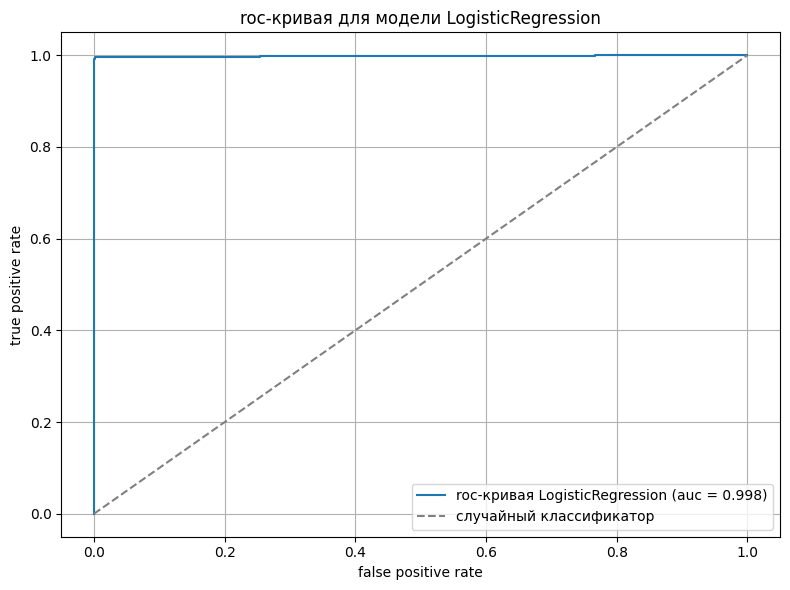

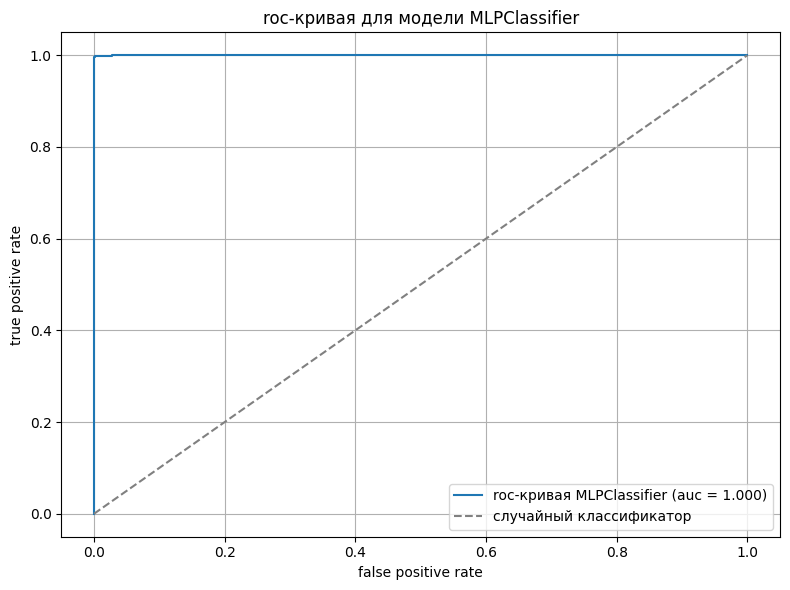

In [20]:
models_multi = (
    catboost_model_gs,
    lightgbm_model_gs,
    xgboost_model_gs,
    tree_model_gs,
    rf_model_gs,
)

# тестовая выборка та же, что использовалась внутри Boosters
X_test_multi = boosters.X_test
y_test_multi = boosters.y_test

evaluator_multi = ModelEvaluator(
    models=models_multi,
    X_test=X_test_multi,
    y_test=y_test_multi,
)

results_multi = evaluator_multi.evaluate(average="macro")

print(" многоклассовые модели с подбором гиперпараметров ")
for model_name, m in results_multi.items():
    print(f"\n{model_name}:")
    print("  accuracy :", f"{m['accuracy']:.4f}")
    print("  precision:", f"{m['precision']:.4f}")
    print("  f1       :", f"{m['f1']:.4f}")
    auc = m["auc"]
    if auc is not None:
        print("  auc      :", f"{auc:.4f}")


models_bin = (
    logreg_model_gs,
    nn_model_gs,
)

# выборки данных из моделей для бинарной классификации 
X_test_bin = logreg_trainer.X_test
y_test_bin = logreg_trainer.y_test

evaluator_bin = ModelEvaluator(
    models=models_bin,
    X_test=X_test_bin,
    y_test=y_test_bin,
    pos_label=1,      # положительный класс — is_table = 1
)

results_bin = evaluator_bin.evaluate(average="binary")

print("\n\n бинарные модели (is_table) с подбором гиперпараметров ")
for model_name, m in results_bin.items():
    print(f"\n{model_name}:")
    print("  accuracy :", f"{m['accuracy']:.4f}")
    print("  precision:", f"{m['precision']:.4f}")
    print("  f1       :", f"{m['f1']:.4f}")
    auc = m["auc"]
    if auc is not None:
        print("  auc      :", f"{auc:.4f}")


evaluator_bin.plot_roc_curve("LogisticRegression")
evaluator_bin.plot_roc_curve("MLPClassifier")